<a href="https://colab.research.google.com/github/KevinBone/TFM_incidentes/blob/main/Proyecto_TFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import folium
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler,OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/sample_data/incidentes.csv', delimiter = ';', encoding='unicode_escape', dtype={'coordenada_x': str, 'coordenada_y': str})

In [ ]:
df.head(15)

,tipo_muerte,distrito,circuito,codigo_subcircuito,subcircuito,provincia,canton,coordenada_y,coordenada_x,area_hecho,...,tipo_lugar,fecha_infraccion,hora_infraccion,arma,tipo_arma,presunta_motivacion,presun_motiva_observada,probable_causa_motivada,edad,sexo
0,ASESINATO,LAGO AGRIO,GENERAL FARFAN,21D02C08S01,GENERAL FARFAN 1,SUCUMBIOS,LAGO AGRIO,"0,117747","-76,779436",RURAL,...,PUBLICO,01/01/2014,01:00,ARMA DE FUEGO,OTRO,VIOLENCIA COMUNITARIA,DEUDAS,HERIDA POR ARMA DE FUEGO,80,HOMBRE
1,HOMICIDIO,TULCAN,JULIO ANDRADE,04D01C10S01,JULIO ANDRADE 1,CARCHI,TULCAN,"0,661967","-77,717049",RURAL,...,PUBLICO,01/01/2014,03:00,ARMA BLANCA,CORTO PUNZANTE,VIOLENCIA COMUNITARIA,RIÑAS,A DETERMINARSE,34,HOMBRE
2,HOMICIDIO,TULCAN,KENNEDY,04D01C08S01,KENNEDY 1,CARCHI,TULCAN,"0,809724","-77,721507",URBANO,...,PUBLICO,01/01/2014,07:00,ARMA BLANCA,CUCHILLO,VIOLENCIA COMUNITARIA,RIÑAS,HERIDA POR ARMA BLANCA,26,HOMBRE
3,ASESINATO,NUEVA PROSPERINA,NUEVA PROSPERINA,09D08C01S01,NUEVA PROSPERINA 1,GUAYAS,GUAYAQUIL,"-2,131332711","-79,9555926",RURAL,...,PRIVADO,01/01/2014,16:30,ARMA BLANCA,CUCHILLO,VIOLENCIA COMUNITARIA,RIÑAS,HERIDA POR ARMA BLANCA,25,HOMBRE
4,ASESINATO,DAULE,SANTA LUCIA,09D19C07S01,SANTA LUCIA 1,GUAYAS,SANTA LUCIA,"-1,713733195","-79,98445702",RURAL,...,PUBLICO,01/01/2014,04:30,ARMA DE FUEGO,PISTOLA,VIOLENCIA COMUNITARIA,RIÑAS,HERIDA POR ARMA DE FUEGO,22,HOMBRE
5,ASESINATO,GUARANDA,SAN LUIS,02D01C10S01,SAN LUIS 1,BOLIVAR,GUARANDA,"-1,2342089","-79,239044",URBANO,...,PUBLICO,01/01/2014,23:30,ARMA DE FUEGO,PISTOLA,DELINCUENCIA COMUN,AMENAZA,HERIDA POR ARMA DE FUEGO,33,HOMBRE
6,ASESINATO,CUENCA NORTE,BARRIAL BLANCO,01D01C06S01,BARRIAL BLANCO 1,AZUAY,CUENCA,"-2,884884108","-78,98876131",URBANO,...,PUBLICO,01/01/2014,00:00,ARMA BLANCA,CUCHILLO,DELINCUENCIA COMUN,ROBO A PERSONAS,HERIDA POR ARMA BLANCA,22,HOMBRE
7,HOMICIDIO,MANUELA SAENZ,EL PLACER,17D04C05S03,EL PLACER 3,PICHINCHA,QUITO,"-0,212218239","-78,52185868",URBANO,...,PRIVADO,01/01/2014,12:30,ARMA BLANCA,OTRO,DELINCUENCIA COMUN,ROBO A PERSONAS,HERIDA POR ARMA BLANCA,22,HOMBRE
8,ASESINATO,RIOBAMBA,LA CONDAMINE,06D01C11S02,LA CONDAMINE 2,CHIMBORAZO,RIOBAMBA,"-1,671697476","-78,65170609",URBANO,...,PUBLICO,01/01/2014,09:00,ARMA BLANCA,CORTO PUNZANTE,DELINCUENCIA COMUN,AMENAZA,HERIDA POR ARMA BLANCA,31,HOMBRE
9,HOMICIDIO,QUITUMBE,GUAMANI,17D07C02S01,GUAMANI 1,PICHINCHA,QUITO,"-0,31865","-78,552896",URBANO,...,PUBLICO,01/01/2014,03:30,ARMA BLANCA,CUCHILLO,VIOLENCIA COMUNITARIA,RIÑAS,HERIDA POR ARMA BLANCA,22,HOMBRE


In [ ]:
df['edad'] = pd.to_numeric(df['edad'], errors='coerce')

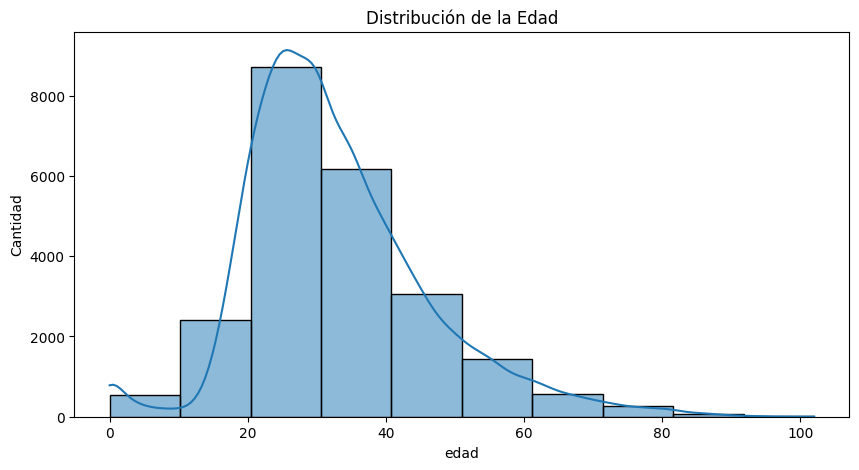

In [ ]:
# Histograma
plt.figure(figsize=(10, 5))
sns.histplot(df['edad'], bins=10, kde=True)
plt.title("Distribución de la Edad")
plt.ylabel("Cantidad")
plt.show()

In [ ]:
df['edad'] = df['edad'].replace(["", " "], np.nan).fillna(df['edad'].median()).astype(int)

In [ ]:
# Asignación de valores numéricos a `arma` y `probable_causa_motivada`
arma_ponderacion = {
    'ARMA DE FUEGO': 10,
    'ARMA BLANCA': 8,
    'ARMA CONTUNDENTE': 6,
    'OTROS': 6,
    'SUSTANCIAS': 4,
    'CONSTRICTORA': 2,
}

'''causa_ponderacion = {
    'HERIDA POR ARMA DE FUEGO': 10,
    'HERIDA POR ARMA BLANCA': 8,
    'HERIDAS CONTUSAS': 7,
    'ESTRANGULACION': 3,
    'EXPLOSION': 6,
    'SOFOCACION': 3,
    'CARBONIZACION': 10,
    'QUEMADURAS': 5,
    'SUMERSION': 5,
    'ELECTROCUCION': 4,
    'INTOXICACION': 4,
    'PRECIPITACION': 3,
    'CAÍDA': 3,
    'APLASTAMIENTO': 4,
    'AHORCADURA': 3,
    'ENFERMEDAD': 2,
    'ATRAGANTAMIENTO': 2,
    'ABORTO': 3,
    'A DETERMINARSE': 1
}'''

presun_motiva_observada_ponderacion = {
    'RIÑAS': 3.33,
    'SENTIMENTAL': 3.33,
    'ROBO A PERSONAS': 6.66,
    'AMENAZA': 6.66,
    'LITIGIO DE TIERRAS': 3.33,
    'TRAFICO INTERNOS DE DROGAS (MICROTRAFICO)': 6.66,
    'EMOCIONAL': 3.33,
    'SECUESTRO': 10,
    'ROBO A DOMICILIOS': 6.66,
    'SECUESTRO EXPRESS': 10,
    'ROBO A UNIDADES ECONÓMICAS': 6.66,
    'ROBO DE MOTOS': 6.66,
    'ACTOS DE ODIO': 6.66,
    'LINCHAMIENTO': 10,
    'MALTRATO': 6.66,
    'TRANSTORNOS MENTALES': 3.33,
    'DEUDAS': 3.33,
    'ROBO DE CARROS': 6.66,
    'VIOLACION SEXUAL (DESCONOCIDO)': 10,
    'VIOLACION FAMILIAR DIRECTO (PERSONA CONOCIDA)': 10,
    'ROBO EN EJES VIALES O CARRETERAS': 6.66,
    'LITIGIO DE BIENES': 3.33,
    'DEFENSA PROPIA': 3.33,
    'ROBO A ENTIDADES FINANCEIRAS': 10,
    'TERRORISMO': 10,
    'TRAFICO INTERNACIONAL DE DROGA': 10,
    'SIN_DATO': 3.33,
    'ROBO DE BIENES PATRIMONIALES': 6.66,
    'EVASION DE LA JUSTICIA': 3.33,
    'ABIGEATO': 6.66,
    'CONTRABANDO': 6.66,
    'TRAFICOS DE MIGRANTES': 6.66,
    'TRATA DE PERSONAS': 10,
    'TRAFICO DE ARMAS': 10,
    'RECEPTACIÓN ILEGAL (CACHINERIA)': 6.66
}


In [ ]:
# Mapear valores a las columnas
df['arma_num'] = df['arma'].map(arma_ponderacion)
df['presun_motiva_observada_num'] = df['presun_motiva_observada'].map(presun_motiva_observada_ponderacion)

# Crear columna de nivel de gravedad combinando los valores
df['nivel_gravedad'] = (df['arma_num'] + df['presun_motiva_observada_num']) / 2

# Transformar "area_hecho" a valores numéricos
#area_mapping = {"URBANO": 1, "RURAL": 0}
#df["area_num"] = df["area_hecho"].map(area_mapping)

In [ ]:
df

,tipo_muerte,distrito,circuito,codigo_subcircuito,subcircuito,provincia,canton,coordenada_y,coordenada_x,area_hecho,...,arma,tipo_arma,presunta_motivacion,presun_motiva_observada,probable_causa_motivada,edad,sexo,arma_num,presun_motiva_observada_num,nivel_gravedad
0,ASESINATO,LAGO AGRIO,GENERAL FARFAN,21D02C08S01,GENERAL FARFAN 1,SUCUMBIOS,LAGO AGRIO,"0,117747","-76,779436",RURAL,...,ARMA DE FUEGO,OTRO,VIOLENCIA COMUNITARIA,DEUDAS,HERIDA POR ARMA DE FUEGO,80,HOMBRE,10,3.33,6.665
1,HOMICIDIO,TULCAN,JULIO ANDRADE,04D01C10S01,JULIO ANDRADE 1,CARCHI,TULCAN,"0,661967","-77,717049",RURAL,...,ARMA BLANCA,CORTO PUNZANTE,VIOLENCIA COMUNITARIA,RIÑAS,A DETERMINARSE,34,HOMBRE,8,3.33,5.665
2,HOMICIDIO,TULCAN,KENNEDY,04D01C08S01,KENNEDY 1,CARCHI,TULCAN,"0,809724","-77,721507",URBANO,...,ARMA BLANCA,CUCHILLO,VIOLENCIA COMUNITARIA,RIÑAS,HERIDA POR ARMA BLANCA,26,HOMBRE,8,3.33,5.665
3,ASESINATO,NUEVA PROSPERINA,NUEVA PROSPERINA,09D08C01S01,NUEVA PROSPERINA 1,GUAYAS,GUAYAQUIL,"-2,131332711","-79,9555926",RURAL,...,ARMA BLANCA,CUCHILLO,VIOLENCIA COMUNITARIA,RIÑAS,HERIDA POR ARMA BLANCA,25,HOMBRE,8,3.33,5.665
4,ASESINATO,DAULE,SANTA LUCIA,09D19C07S01,SANTA LUCIA 1,GUAYAS,SANTA LUCIA,"-1,713733195","-79,98445702",RURAL,...,ARMA DE FUEGO,PISTOLA,VIOLENCIA COMUNITARIA,RIÑAS,HERIDA POR ARMA DE FUEGO,22,HOMBRE,10,3.33,6.665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23443,FEMICIDIO,TULCAN,COMUNEROS,04D01C03S01,COMUNEROS 1,CARCHI,TULCAN,"0,84051","-77,72522",RURAL,...,OTROS,NINGUNA,VIOLENCIA INTRAFAMILIAR,MALTRATO,AHORCADURA,4,MUJER,6,6.66,6.330
23444,FEMICIDIO,TULCAN,COMUNEROS,04D01C03S01,COMUNEROS 1,CARCHI,TULCAN,"0,84154","-77,72545",RURAL,...,OTROS,NINGUNA,VIOLENCIA INTRAFAMILIAR,MALTRATO,ESTRANGULACION,11,MUJER,6,6.66,6.330
23445,ASESINATO,QUEVEDO,GALO PLAZA,12D03C05S02,GALO PLAZA 2,LOS RIOS,QUEVEDO,"-1,01842","-79,46311",URBANO,...,ARMA DE FUEGO,PISTOLA,DELINCUENCIA COMUN,AMENAZA,HERIDA POR ARMA DE FUEGO,57,HOMBRE,10,6.66,8.330
23446,ASESINATO,LOJA,CELI ROMAN,11D01C08S01,CELI ROMAN 1,LOJA,LOJA,"-3,99368","-79,20609",URBANO,...,ARMA DE FUEGO,REVOLVER,DELINCUENCIA COMUN,AMENAZA,HERIDA POR ARMA DE FUEGO,24,HOMBRE,10,6.66,8.330


In [ ]:
count = ((df['coordenada_x'] == "SIN_DATO") | (df['coordenada_x'] == '0')).sum()

print("Cantidad de filas:", count)
df = df.drop(df[(df['coordenada_x'] == "SIN_DATO") | (df['coordenada_x'] == '0')].index)


Cantidad de filas: 9328


In [ ]:
df

,tipo_muerte,distrito,circuito,codigo_subcircuito,subcircuito,provincia,canton,coordenada_y,coordenada_x,area_hecho,...,arma,tipo_arma,presunta_motivacion,presun_motiva_observada,probable_causa_motivada,edad,sexo,arma_num,presun_motiva_observada_num,nivel_gravedad
0,ASESINATO,LAGO AGRIO,GENERAL FARFAN,21D02C08S01,GENERAL FARFAN 1,SUCUMBIOS,LAGO AGRIO,"0,117747","-76,779436",RURAL,...,ARMA DE FUEGO,OTRO,VIOLENCIA COMUNITARIA,DEUDAS,HERIDA POR ARMA DE FUEGO,80,HOMBRE,10,3.33,6.665
1,HOMICIDIO,TULCAN,JULIO ANDRADE,04D01C10S01,JULIO ANDRADE 1,CARCHI,TULCAN,"0,661967","-77,717049",RURAL,...,ARMA BLANCA,CORTO PUNZANTE,VIOLENCIA COMUNITARIA,RIÑAS,A DETERMINARSE,34,HOMBRE,8,3.33,5.665
2,HOMICIDIO,TULCAN,KENNEDY,04D01C08S01,KENNEDY 1,CARCHI,TULCAN,"0,809724","-77,721507",URBANO,...,ARMA BLANCA,CUCHILLO,VIOLENCIA COMUNITARIA,RIÑAS,HERIDA POR ARMA BLANCA,26,HOMBRE,8,3.33,5.665
3,ASESINATO,NUEVA PROSPERINA,NUEVA PROSPERINA,09D08C01S01,NUEVA PROSPERINA 1,GUAYAS,GUAYAQUIL,"-2,131332711","-79,9555926",RURAL,...,ARMA BLANCA,CUCHILLO,VIOLENCIA COMUNITARIA,RIÑAS,HERIDA POR ARMA BLANCA,25,HOMBRE,8,3.33,5.665
4,ASESINATO,DAULE,SANTA LUCIA,09D19C07S01,SANTA LUCIA 1,GUAYAS,SANTA LUCIA,"-1,713733195","-79,98445702",RURAL,...,ARMA DE FUEGO,PISTOLA,VIOLENCIA COMUNITARIA,RIÑAS,HERIDA POR ARMA DE FUEGO,22,HOMBRE,10,3.33,6.665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23443,FEMICIDIO,TULCAN,COMUNEROS,04D01C03S01,COMUNEROS 1,CARCHI,TULCAN,"0,84051","-77,72522",RURAL,...,OTROS,NINGUNA,VIOLENCIA INTRAFAMILIAR,MALTRATO,AHORCADURA,4,MUJER,6,6.66,6.330
23444,FEMICIDIO,TULCAN,COMUNEROS,04D01C03S01,COMUNEROS 1,CARCHI,TULCAN,"0,84154","-77,72545",RURAL,...,OTROS,NINGUNA,VIOLENCIA INTRAFAMILIAR,MALTRATO,ESTRANGULACION,11,MUJER,6,6.66,6.330
23445,ASESINATO,QUEVEDO,GALO PLAZA,12D03C05S02,GALO PLAZA 2,LOS RIOS,QUEVEDO,"-1,01842","-79,46311",URBANO,...,ARMA DE FUEGO,PISTOLA,DELINCUENCIA COMUN,AMENAZA,HERIDA POR ARMA DE FUEGO,57,HOMBRE,10,6.66,8.330
23446,ASESINATO,LOJA,CELI ROMAN,11D01C08S01,CELI ROMAN 1,LOJA,LOJA,"-3,99368","-79,20609",URBANO,...,ARMA DE FUEGO,REVOLVER,DELINCUENCIA COMUN,AMENAZA,HERIDA POR ARMA DE FUEGO,24,HOMBRE,10,6.66,8.330


In [ ]:
zona_delincuencia = df.groupby('codigo_subcircuito').agg(
    frecuencia=('tipo_muerte', 'count'),
    gravedad_promedio=('nivel_gravedad', 'mean')
).reset_index()

In [ ]:
zona_delincuencia

,codigo_subcircuito,frecuencia,gravedad_promedio
0,000C01S01,70,7.868214
1,000C02S01,5,6.331000
2,000C03S01,9,6.923333
3,000C04S01,9,7.737778
4,01D01C01S01,1,4.665000
...,...,...,...
1590,24D02C06S01,4,7.413750
1591,24D02C06S03,11,7.572727
1592,24D02C07S01,16,7.976250
1593,24D02C07S02,17,7.506765


In [ ]:
def clasificar_nivel(frecuencia, gravedad_promedio):
    promedio = (frecuencia + gravedad_promedio) / 2
    if promedio > 15:
        return 'ALTO'
    elif 7 <= promedio <= 15:
        return 'MEDIO'
    else:
        return 'BAJO'

zona_delincuencia['nivel_delincuencia'] = zona_delincuencia.apply(
    lambda row: clasificar_nivel(row['frecuencia'], row['gravedad_promedio']),
    axis=1
)

In [ ]:
zona_delincuencia

,codigo_subcircuito,frecuencia,gravedad_promedio,nivel_delincuencia
0,000C01S01,70,7.868214,ALTO
1,000C02S01,5,6.331000,BAJO
2,000C03S01,9,6.923333,MEDIO
3,000C04S01,9,7.737778,MEDIO
4,01D01C01S01,1,4.665000,BAJO
...,...,...,...,...
1590,24D02C06S01,4,7.413750,BAJO
1591,24D02C06S03,11,7.572727,MEDIO
1592,24D02C07S01,16,7.976250,MEDIO
1593,24D02C07S02,17,7.506765,MEDIO


In [ ]:
# Añadir el nivel de delincuencia al dataset original
df = df.merge(
    zona_delincuencia[['codigo_subcircuito', 'nivel_delincuencia']],
    on='codigo_subcircuito',
    how='left'
)

In [ ]:
df['coordenada_x'] = df['coordenada_x'].astype(str)
df['coordenada_y'] = df['coordenada_y'].astype(str)
df['edad'] = df['edad'].astype(int)
df.to_csv('incidenteV2.csv', index=False, quotechar='"', quoting=1)

In [ ]:
df_entrenamiento = df[['circuito','codigo_subcircuito','provincia','canton','area_hecho','arma','tipo_arma','probable_causa_motivada', 'presun_motiva_observada','nivel_delincuencia']]

columnas_categoricas = ['circuito','codigo_subcircuito', 'provincia','canton','area_hecho','arma', 'tipo_arma', 'presun_motiva_observada','probable_causa_motivada']
columna_ordinal = 'nivel_delincuencia'

In [ ]:
conteo_niveles = df_entrenamiento.groupby('nivel_delincuencia').size().reset_index(name='conteo')
print(conteo_niveles)

  nivel_delincuencia  conteo
0               ALTO    5499
1               BAJO    2789
2              MEDIO    5832


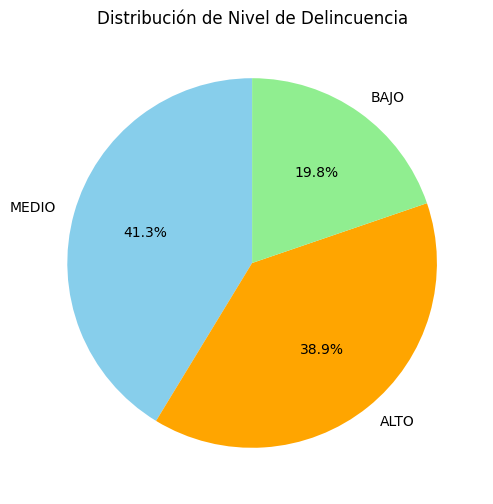

In [ ]:
conteo_niveles = df_entrenamiento['nivel_delincuencia'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(conteo_niveles, labels=conteo_niveles.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange', 'lightgreen'])
plt.title('Distribución de Nivel de Delincuencia')
plt.show()

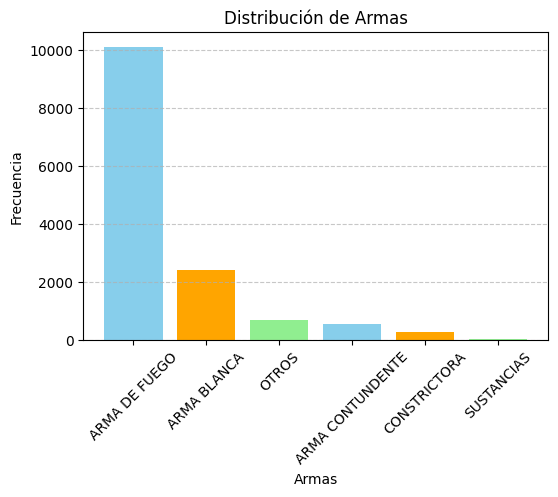

In [ ]:
conteo_niveles = df_entrenamiento['arma'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(conteo_niveles.index, conteo_niveles.values, color=['skyblue', 'orange', 'lightgreen'])
plt.title('Distribución de Armas')
plt.xlabel('Armas')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

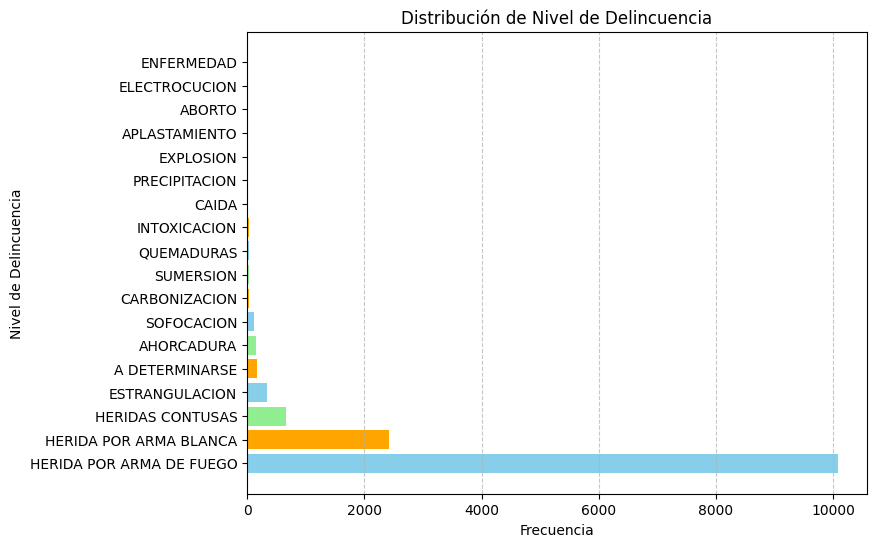

In [ ]:
conteo_niveles = df_entrenamiento['probable_causa_motivada'].value_counts()
plt.figure(figsize=(8, 6))
plt.barh(conteo_niveles.index, conteo_niveles.values, color=['skyblue', 'orange', 'lightgreen'])
plt.title('Distribución de Nivel de Delincuencia')
plt.xlabel('Frecuencia')
plt.ylabel('Nivel de Delincuencia')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Dividir el dataframe
X = df_entrenamiento[columnas_categoricas]
y = df_entrenamiento['nivel_delincuencia']

In [ ]:
# Codificación One-Hot
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Para evitar colinealidad
X_encoded = encoder.fit_transform(X)

In [ ]:
# Codificación ordinal para 'nivel_delincuencia'
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

In [ ]:
# Compilación del modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Entrenamiento del modelo
model.fit(X_train, y_train, epochs=50, batch_size=8, validation_split=0.2)

Epoch 1/50
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7194 - loss: 0.6103 - val_accuracy: 0.9845 - val_loss: 0.0525
Epoch 2/50
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9957 - loss: 0.0178 - val_accuracy: 0.9956 - val_loss: 0.0181
Epoch 3/50
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9965 - val_loss: 0.0173
Epoch 4/50
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 1.0000 - loss: 2.8068e-04 - val_accuracy: 0.9965 - val_loss: 0.0180
Epoch 5/50
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 1.0000 - loss: 1.1364e-04 - val_accuracy: 0.9965 - val_loss: 0.0182
Epoch 6/50
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 1.0000 - loss: 5.5527e-05 - val_accuracy: 0.9965 - val_loss: 0.0193
Epoch 7/50
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 1.0000 - loss: 2.7606e-05 - val_accuracy: 0.9960 - val_loss: 0.0200
Epoch 8/50
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 1.0000 

In [ ]:
# Evaluar el modelo con el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir probabilidades a etiquetas de clase


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


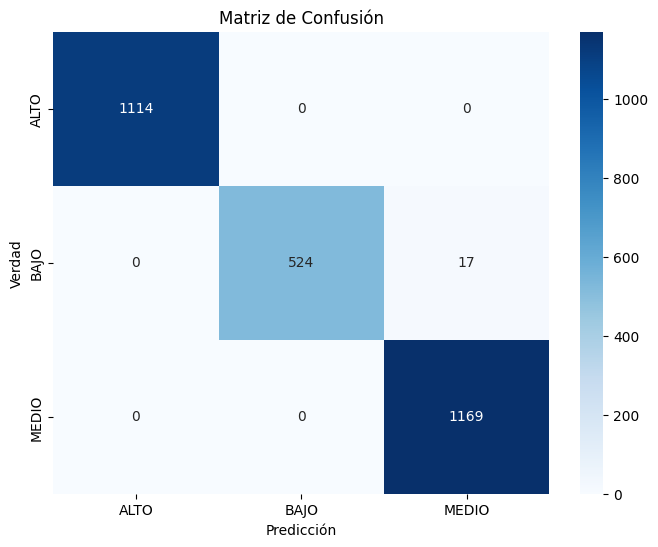

In [ ]:
# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicción')
plt.ylabel('Verdad')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
# Reporte de Clasificación
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

Reporte de Clasificación:
              precision    recall  f1-score   support

        ALTO       1.00      1.00      1.00      1114
        BAJO       1.00      0.97      0.98       541
       MEDIO       0.99      1.00      0.99      1169

    accuracy                           0.99      2824
   macro avg       1.00      0.99      0.99      2824
weighted avg       0.99      0.99      0.99      2824



In [ ]:
# Obtener reporte de clasificación como diccionario
report_dict = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_, output_dict=True)

# Extraer precisión, recall y F1-score
classes = list(report_dict.keys())[:-3]  # Excluir 'accuracy', 'macro avg' y 'weighted avg'
precision = [report_dict[c]['precision'] for c in classes]
recall = [report_dict[c]['recall'] for c in classes]
f1_score = [report_dict[c]['f1-score'] for c in classes]

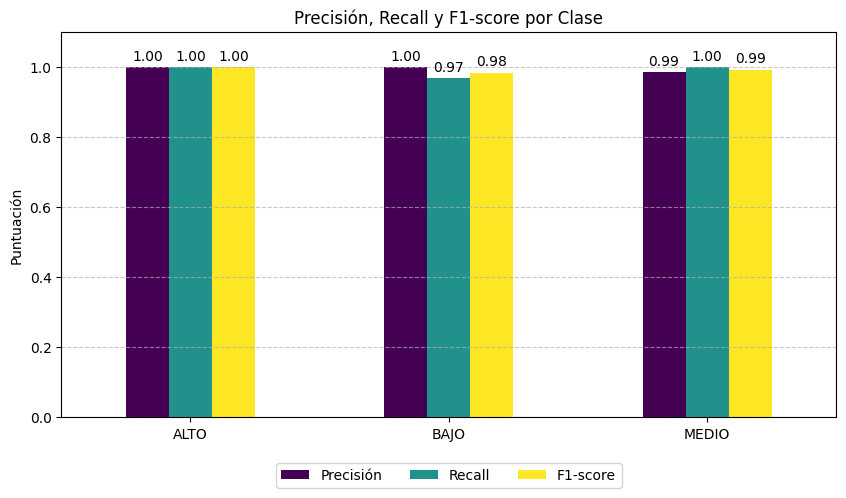

In [ ]:
df_metrics = pd.DataFrame({'Clase': classes, 'Precisión': precision, 'Recall': recall, 'F1-score': f1_score})

# Gráfico de Barras para Precisión, Recall y F1-score
fig, ax = plt.subplots(figsize=(10, 5))
df_metrics.set_index('Clase').plot(kind='bar', ax=ax, colormap="viridis")

# Añadir etiquetas de porcentaje sobre cada barra
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", padding=3, fontsize=10)
plt.title('Precisión, Recall y F1-score por Clase')
plt.ylabel('Puntuación')
plt.xlabel('')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.show()